In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# 超参数设置
input_size = 28  # 输入图像的宽度（28x28像素）
sequence_length = 28  # 每行图像作为一个序列
hidden_size = 128  # LSTM的隐藏层大小
num_layers = 2  # LSTM的层数
num_classes = 10  # 类别数
batch_size = 64  # 批量大小
learning_rate = 0.001  # 学习率
num_epochs = 10  # 训练的轮数

In [ ]:
#使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f"device: {device}")

In [4]:
# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # 标准化
])

In [5]:
# 加载MNIST数据集
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# 定义自注意力模块
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, H, W = x.size()
        
        # 查询、键、值
        query = self.query_conv(x).view(batch_size, -1, H * W).permute(0, 2, 1)
        key = self.key_conv(x).view(batch_size, -1, H * W)
        value = self.value_conv(x).view(batch_size, -1, H * W)

        # 计算注意力
        attention = torch.bmm(query, key)  # batch_size x (H*W) x (H*W)
        attention = torch.softmax(attention, dim=-1)  # 使用softmax进行归一化
        
        # 生成加权输出
        out = torch.bmm(value, attention.permute(0, 2, 1))  # batch_size x C x (H*W)
        out = out.view(batch_size, C, H, W)

        # 加权输出与输入特征图的融合
        out = self.gamma * out + x
        return out

In [ ]:
class CNNWithAttention(nn.Module):
    def __init__(self):
        super(CNNWithAttention, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        # 自注意力层
        self.attention = SelfAttention(64)

        # 全连接层
        self.fc1 = nn.Linear(7 * 7 * 64, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)  # 14x14
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)  # 7x7
        x = torch.relu(self.conv3(x))

        # 自注意力机制
        x = self.attention(x)

        # 展平数据为(batch_size, 7*7*64)
        x = x.view(x.size(0), -1)

        # 全连接层
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.sigmoid(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # x: [batch_size, sequence_length, input_size]
        out, (hn, cn) = self.lstm(x)
        # 只取最后一个时刻的输出（即整张图像的特征）
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
#定义 ResNet 网络结构
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        # 加载 ResNet18 结构（不使用预训练权重）
        self.resnet = models.resnet18(pretrained=False)
        
        # 修改 ResNet 的第一层卷积层，以适应单通道
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # 修改 ResNet 的最后一层全连接层，以适应 10 类分类任务
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 10)

    def forward(self, x):
        return self.resnet(x)

In [ ]:
#训练模型
def train(model, train_loader, criterion, optimizer, num_epochs, model_name):
    print(f"Train: {model_name}")
    model.train()
    model.to(device)  # 将模型移到GPU

    train_losses = []  # 用于记录每个epoch的训练损失
    test_accuracies = []  # 用于记录每个epoch的测试准确率
    
    for epoch in range(num_epochs):
        #每轮设置为train模式
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
            # 将图像数据转换为 [batch_size, sequence_length, input_size]（LSTM模型）
            if model_name == 'LSTM':
                images = images.view(-1, sequence_length, input_size)

            # 将数据移到GPU
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, labels)
            # 反向传播和优化
            loss.backward()

            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # 记录测试集准确率
        accuracy = test(model, test_loader)
        test_accuracies.append(accuracy)
        
    # 保存模型
    #torch.save({
        #'epoch': num_epochs,
        #'model_state_dict': model.state_dict(),
        #'optimizer_state_dict': optimizer.state_dict(),
        #'loss': avg_loss,
    #}, f'{model_name}_model.pth')
    #print(f"Model saved as '{model_name}_model.pth'.")
    
    # 绘制训练损失图
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs+1), train_losses, marker='o', color='r')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Training Loss per Epoch')
    plt.show()  

    # 绘制测试准确率图
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs+1), test_accuracies, marker='o', color='g')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{model_name} - Test Accuracy per Epoch')
    plt.show()

In [12]:
def test(model, test_loader):
    model.eval()
    model.to(device)  # 将模型移到GPU
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            if isinstance(model, LSTM):
                images = images.view(-1, sequence_length, input_size)
            
            # 将数据移到GPU
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

C:\anaconda3\envs\hand_write\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\anaconda3\envs\hand_write\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Train: CNNWithAttention


Epoch 1/10: 100%|████████████████████████████████████████████████████████████████| 938/938 [00:08<00:00, 113.62batch/s]


Epoch [1/10], Loss: 0.15718169631173354


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 97.94batch/s]


Epoch [2/10], Loss: 0.04434842301601135


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 98.06batch/s]


Epoch [3/10], Loss: 0.03179314481901816


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 101.30batch/s]


Epoch [4/10], Loss: 0.02277986019952975


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 100.64batch/s]


Epoch [5/10], Loss: 0.01865889209933393


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 101.81batch/s]


Epoch [6/10], Loss: 0.01597608634261218


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 102.94batch/s]


Epoch [7/10], Loss: 0.01249330349749564


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████| 938/938 [00:08<00:00, 111.89batch/s]


Epoch [8/10], Loss: 0.010279067073470424


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████| 938/938 [00:08<00:00, 111.74batch/s]


Epoch [9/10], Loss: 0.009248337793167744


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████| 938/938 [00:08<00:00, 115.97batch/s]


Epoch [10/10], Loss: 0.008350671620952937


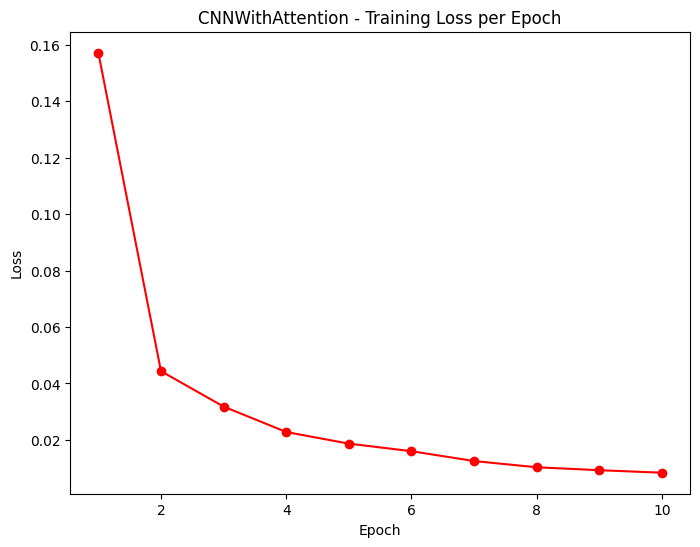

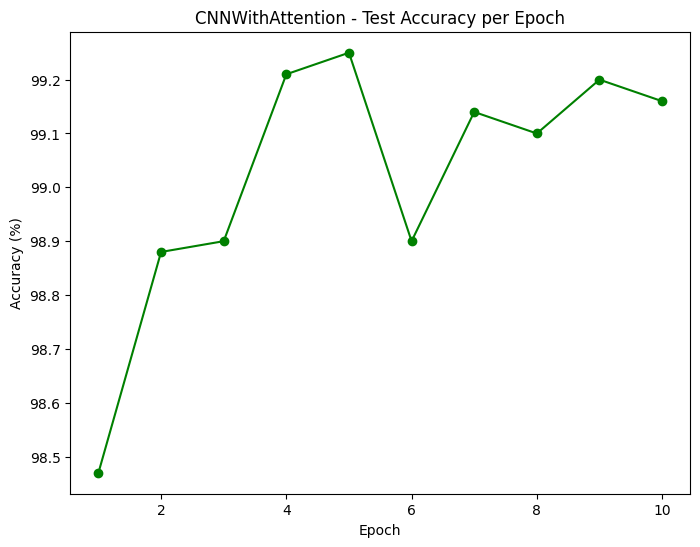

Train: MLP


Epoch 1/10: 100%|████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 133.32batch/s]


Epoch [1/10], Loss: 1.7328978961210515


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 130.48batch/s]


Epoch [2/10], Loss: 1.544740870054851


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 129.49batch/s]


Epoch [3/10], Loss: 1.5230406086836288


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████| 938/938 [00:06<00:00, 139.80batch/s]


Epoch [4/10], Loss: 1.5144865589101177


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 131.12batch/s]


Epoch [5/10], Loss: 1.5084603863484316


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 129.74batch/s]


Epoch [6/10], Loss: 1.5041418713547274


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████| 938/938 [00:06<00:00, 134.17batch/s]


Epoch [7/10], Loss: 1.4999469950763402


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████| 938/938 [00:06<00:00, 134.98batch/s]


Epoch [8/10], Loss: 1.4970141945363107


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████| 938/938 [00:06<00:00, 134.57batch/s]


Epoch [9/10], Loss: 1.4950557070246129


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 126.87batch/s]


Epoch [10/10], Loss: 1.492480541216031


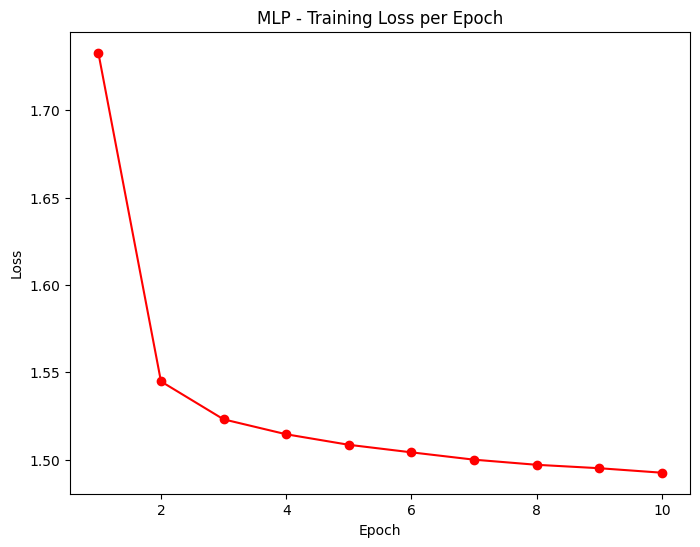

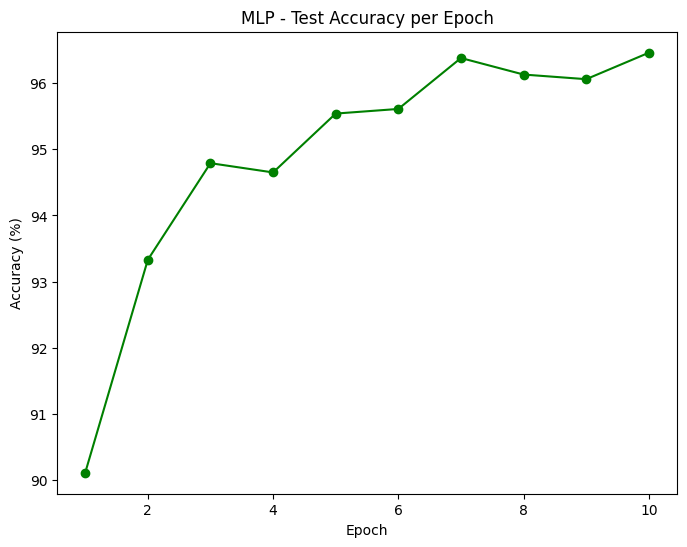

Train: LSTM


Epoch 1/10: 100%|████████████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 100.32batch/s]


Epoch [1/10], Loss: 0.3596570532280467


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 102.79batch/s]


Epoch [2/10], Loss: 0.08972909790711966


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 103.84batch/s]


Epoch [3/10], Loss: 0.06299427495465111


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 102.42batch/s]


Epoch [4/10], Loss: 0.04943138091012772


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 102.96batch/s]


Epoch [5/10], Loss: 0.041483862001993964


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 101.69batch/s]


Epoch [6/10], Loss: 0.03328703254223493


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 99.42batch/s]


Epoch [7/10], Loss: 0.02821967942382781


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 98.41batch/s]


Epoch [8/10], Loss: 0.027086586772141777


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 97.08batch/s]


Epoch [9/10], Loss: 0.022455191342663994


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 95.48batch/s]


Epoch [10/10], Loss: 0.02072719128827613


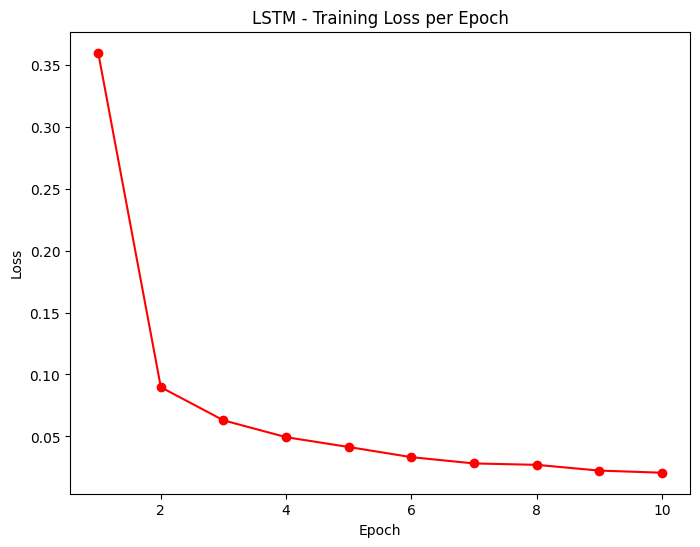

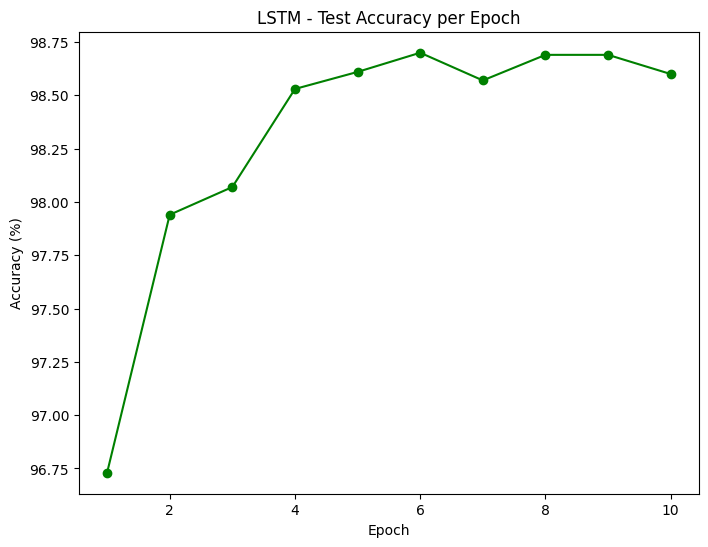

Train: ResNet


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 43.30batch/s]


Epoch [1/10], Loss: 0.13506079456463121


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 44.05batch/s]


Epoch [2/10], Loss: 0.0607841203022358


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 43.70batch/s]


Epoch [3/10], Loss: 0.0460121342321552


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 44.53batch/s]


Epoch [4/10], Loss: 0.03777799763495097


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████| 938/938 [00:20<00:00, 44.69batch/s]


Epoch [5/10], Loss: 0.03581499951405834


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 43.81batch/s]


Epoch [6/10], Loss: 0.030021257340881492


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 43.72batch/s]


Epoch [7/10], Loss: 0.02555242831225854


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 44.04batch/s]


Epoch [8/10], Loss: 0.0237140555773236


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 43.50batch/s]


Epoch [9/10], Loss: 0.019629168678037687


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████| 938/938 [00:21<00:00, 43.78batch/s]


Epoch [10/10], Loss: 0.020288523032100932


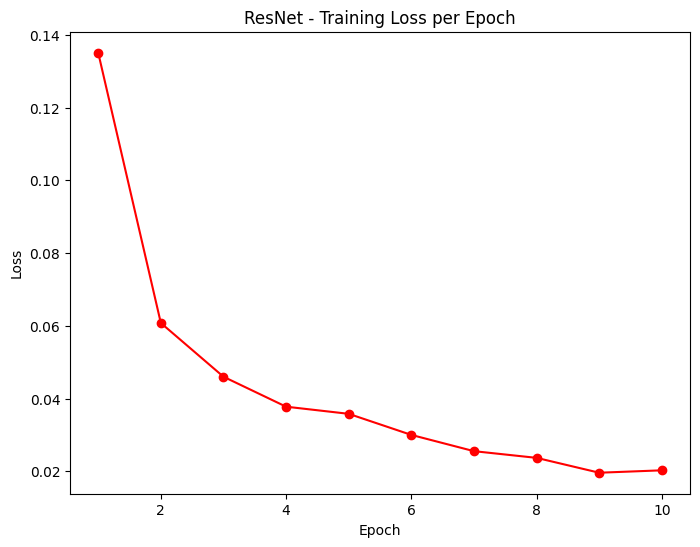

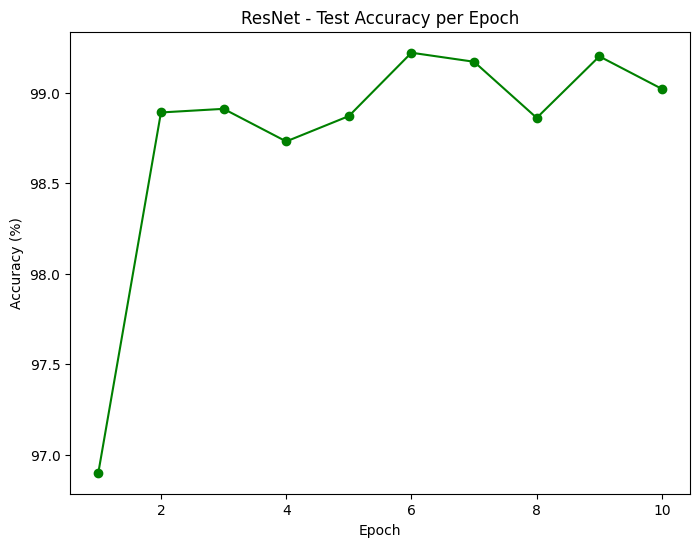

In [13]:
if __name__ == "__main__":
    # 训练并测试模型
    model_list = {
        "CNNWithAttention":CNNWithAttention(),
        "MLP":MLP(),
        "LSTM":LSTM(),
        "ResNet":ResNetModel()
    }

    for model_name, model in model_list.items():
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        train(model, train_loader, criterion, optimizer, num_epochs, model_name)